In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
root_dir = './data/'
img_path = root_dir + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'
train_dir = img_path + 'train'
test_dir = img_path + 'test'

In [3]:
metadata = pd.read_csv(os.path.join(root_dir, 'Chest_xray_Corona_Metadata.csv'))
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
metadata.describe()

,Unnamed: 0
count,5910.000000
mean,2957.075635
std,1710.186149
min,0.000000
25%,1477.250000
50%,2954.500000
75%,4431.750000
max,5932.000000


In [5]:
# count null values
for c in metadata.columns:
    print('Number of empty/missing values on column {}: {}'.format(c, metadata[c].isnull().sum()))

Number of empty/missing values on column Unnamed: 0: 0
Number of empty/missing values on column X_ray_image_name: 0
Number of empty/missing values on column Label: 0
Number of empty/missing values on column Dataset_type: 0
Number of empty/missing values on column Label_2_Virus_category: 5841
Number of empty/missing values on column Label_1_Virus_category: 1576


In [6]:
# replace those empty values by a default value
metadata = metadata.fillna(value='unknown')
metadata.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

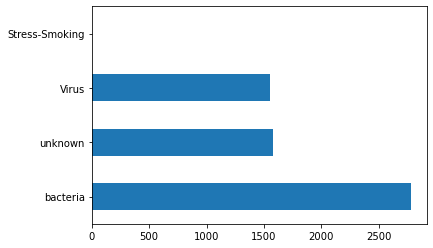

In [7]:
virus_category_1 = metadata['Label_1_Virus_category'].value_counts()
virus_category_1.plot(kind='barh')

plt.show()

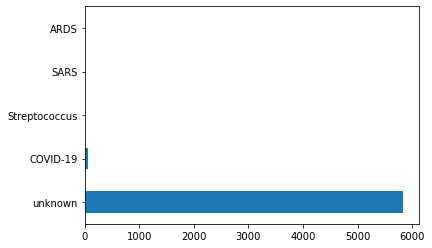

In [8]:
virus_category_2 = metadata['Label_2_Virus_category'].value_counts()
virus_category_2.plot(kind='barh')

plt.show()

<AxesSubplot:>

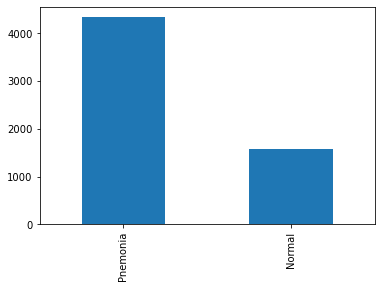

In [9]:
label = metadata['Label'].value_counts()
label.plot(kind='bar')

In [10]:
df_train = metadata[metadata['Dataset_type']=='TRAIN']
df_test = metadata[metadata['Dataset_type']=='TEST']

print('Training data:', df_train.shape)
print('Testing data:', df_test.shape)

Training data: (5286, 6)
Testing data: (624, 6)


In [11]:
df_train.loc[df_train['Label'].eq('Normal'), 'class'] = 'healthy'
df_train.loc[(df_train['class'].ne('healthy') & df_train['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'bacteria';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['class'].ne('COVID-19')), 'class'] = 'other';

df_test.loc[df_test['Label'].eq('Normal'), 'class'] = 'healthy'
df_test.loc[(df_test['class'].ne('healthy') & df_test['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'bacteria';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['class'].ne('COVID-19')), 'class'] = 'other';

print(df_train['class'].value_counts())
print(df_test['class'].value_counts())

bacteria    2535
other       1351
healthy     1342
COVID-19      58
Name: class, dtype: int64
bacteria    242
healthy     234
other       148
Name: class, dtype: int64


C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
target_dict = {'healthy': 0, 'bacteria': 1, 'COVID-19': 2, 'other': 3}
df_train['target'] = df_train['class'].map(target_dict)
df_test['target'] = df_test['class'].map(target_dict)

df_test.head()

<ipython-input-12-f510ec5992e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target'] = df_train['class'].map(target_dict)
<ipython-input-12-f510ec5992e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target'] = df_test['class'].map(target_dict)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,class,target
5286,5309,IM-0021-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5287,5310,IM-0019-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5288,5311,IM-0017-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5289,5312,IM-0016-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5290,5313,IM-0015-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0


In [13]:
def plot_img_hist(path, label, num_of_images):
    fig, ax = plt.subplots(num_of_images, 2, figsize=(15, 2.5*num_of_images))
    
    for i, file in enumerate(path):
        im = plt.imread(file)
        ax[i,0].imshow(im, cmap=plt.cm.bone)
        ax[i,1].hist(im.ravel(), 256, [0,256])
        ax[i,0].axis('off')
        
        if i == 0:
            ax[i,0].set_title('X-rays')
            ax[i,1].set_title('Histograms')
        
    fig.suptitle('Target: {}'.format(label), size=16)
    
    plt.show()
    
def display_img_hist(img_path, dset, split, label, num_of_images):
    path = dset[dset['class']==label]['X_ray_image_name'].values
    sample_path = path[:num_of_images]
    img_dir = img_path + split
#     print(img_dir)
    sample_path = list(map(lambda x: os.path.join(img_dir, x), sample_path))
#     print(sample_path)
    
    plot_img_hist(sample_path, label, num_of_images)

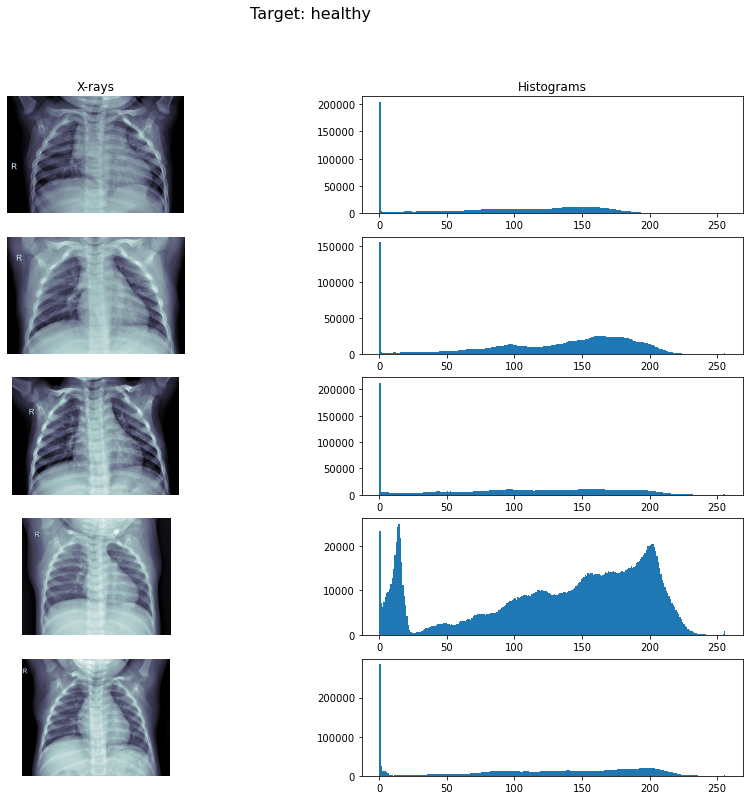

In [14]:
display_img_hist(img_path, df_train, 'train', 'healthy', 5)

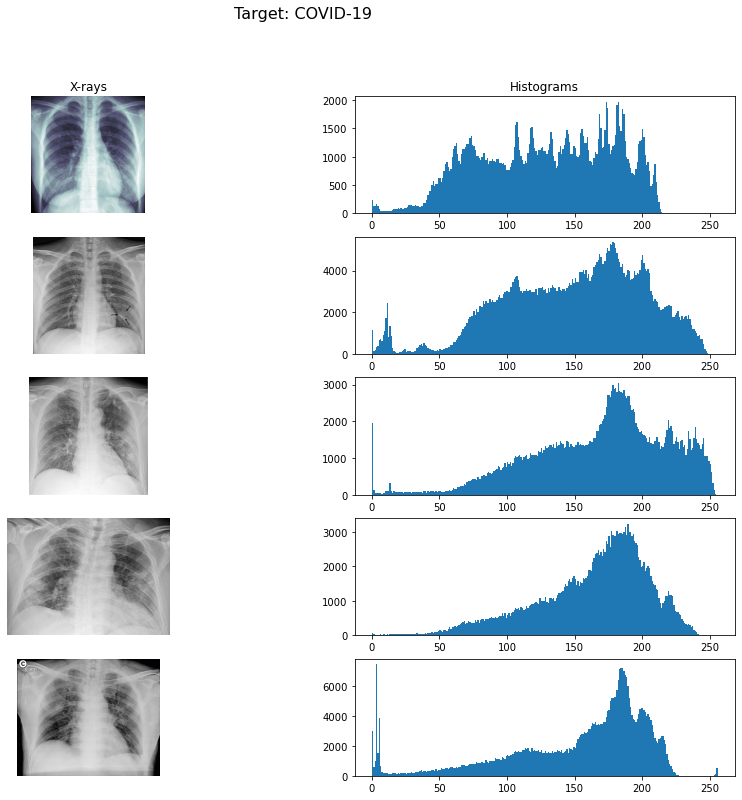

In [15]:
display_img_hist(img_path, df_train, 'train', 'COVID-19', 5)

In [16]:
class CoronaHackDataset(Dataset):
    
    def __init__(self, metadata, root_dir, transform=None):
        self.root_dir = root_dir
        self.metadata = metadata
        self.transform = transform
        self.list_dir = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        metadata = self.metadata.iloc[idx]
        fname = metadata['X_ray_image_name']
        
        try:
            file_idx = self.list_dir.index(fname)
        except:
            print('Image not found!')
            return None
        
        img_path = os.path.join(self.root_dir, self.list_dir[file_idx])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((128,128))
        tensor_img = self.transform(img)
        tensor_lbl = torch.tensor(metadata['target'].item())
        
        return tensor_img, tensor_lbl

In [17]:
batch_size = 32
normalize = False
stats = ((0.0093, 0.0093, 0.0092),(0.4827, 0.4828, 0.4828))

if normalize:
    train_tfms = torchvision.transforms.ToTensor()
else:
    train_tfms = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(128), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])
    
test_tfms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])

In [18]:
train_ds, val_ds = train_test_split(df_train, test_size=0.1, random_state=1, shuffle=True)
train_ds, val_ds = train_ds.reset_index(drop=True), val_ds.reset_index(drop=True)

In [19]:
print('Total data:', len(metadata))
print('--After splitting--')
print('Train: {}'.format(len(train_ds)))
print('Validation: {}'.format(len(val_ds)))
print('Test: {}'.format(len(df_test)))

Total data: 5910
--After splitting--
Train: 4757
Validation: 529
Test: 624


In [20]:
train_dataset = CoronaHackDataset(train_ds, train_dir, transform=train_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

valid_dataset = CoronaHackDataset(val_ds, train_dir, transform=test_tfms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_dataset = CoronaHackDataset(df_test, test_dir, transform=test_tfms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [21]:
class BaselineModel(nn.Module):
    
    def __init__(self):
        super(BaselineModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.linear1 = nn.Linear(2048*4*4, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
#         print(x.shape)
        
        x = self.flatten(x)
#         print(x.shape)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        out = F.relu(self.linear3(x))
        
        return out

In [22]:
base = BaselineModel()
base

BaselineModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (relu): ReLU()
  (linear1): Linear(in_features=32768, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=4, bias=True)
)

In [23]:
def train(num_epochs, train_loader, val_loader, model, optimizer, criterion, use_cuda, save_path=''):
    for i in range(num_epochs):
        training_loss = 0.0
        val_loss = 0.0
        
        # training phase
        model.train()
        for batch, (data, lbl) in enumerate(train_loader):
#             data = data.to(torch.float32)
#             lbl = lbl.to(torch.long)
            if use_cuda:
                data, lbl = data.cuda(), lbl.cuda()
                
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, lbl)
            loss.backward()
            optimizer.step()
            
            training_loss = training_loss + ((1/(batch+1)) * (loss.data - training_loss))
        
        # evaluation phase
        model.eval()
        for batch, (data, lbl) in enumerate(val_loader):
            if use_cuda:
                data, lbl = data.cuda(), lbl.cuda()
                
            output = model(data)
            loss = criterion(output, lbl)
            
            val_loss += loss.item()
        
        print('Epoch #{}: Training loss={} | Validation loss={}'.format(i+1, training_loss, val_loss))
    
    if len(save_path) > 0:
        torch.save(model.state_dict(), save_path)
    
    return model

In [24]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    base = base.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base.parameters(), lr=0.001)

In [25]:
train(10, train_loader, valid_loader, base, optimizer, criterion, use_cuda)

Epoch #1: Training loss=1.1860753297805786 | Validation loss=16.841764509677887
Epoch #2: Training loss=0.7214502096176147 | Validation loss=10.311081886291504
Epoch #3: Training loss=0.5757949948310852 | Validation loss=9.811557024717331
Epoch #4: Training loss=0.5286918878555298 | Validation loss=9.183850020170212
Epoch #5: Training loss=0.48672208189964294 | Validation loss=8.973269253969193
Epoch #6: Training loss=0.4552499055862427 | Validation loss=8.938761055469513
Epoch #7: Training loss=0.42482271790504456 | Validation loss=9.395192384719849
Epoch #8: Training loss=0.4022495746612549 | Validation loss=9.798147678375244
Epoch #9: Training loss=0.3997947573661804 | Validation loss=10.408427774906158
Epoch #10: Training loss=0.3722965717315674 | Validation loss=9.742002725601196


BaselineModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (relu): ReLU()
  (linear1): Linear(in_features=32768, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=4, bias=True)
)

In [26]:
def test()

SyntaxError: invalid syntax (<ipython-input-26-b746679f0777>, line 1)